In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx

In [4]:
TRACE_FNAME = "../trace.out"

storage = defaultdict(lambda: {"r": set(), "w": set()})

with open(TRACE_FNAME, "r") as fp:
    for line in fp:
        if not line.startswith("#"):
            continue
        # print(line.strip()[2:-1].split(";"))
        mode, txn_idx, incarnation, key = line.strip()[2:-1].split(";")

        txn_idx = int(txn_idx)
        incarnation = int(incarnation)

        storage[(txn_idx, incarnation)][mode].add(key)

        print(mode, txn_idx, incarnation, key)


w 0 0 Basic(0x494cc492c9f01699bff1449180201dbfbd592ea5)
w 0 0 Basic(0x75481fdcd458522badb48e8b0d679174321b85e5)
w 0 0 Storage(0x75481fdcd458522badb48e8b0d679174321b85e5, 0x0000000000000000000000000000000000000000000000000000000000000009_U256)
w 3 0 Basic(0xb225fc43175aba4076493be893b20d724352e05f)
w 3 0 Basic(0x2bc812c70dcd634a07ce4fb9cd9ba4319fd9898d)
r 3 0 Basic(0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c)
r 3 0 Basic(0x2bc812c70dcd634a07ce4fb9cd9ba4319fd9898d)
r 3 0 Basic(0xb225fc43175aba4076493be893b20d724352e05f)
w 4 0 Basic(0x9e303e1b47e5c174ebb20ceb0d11015f4d14b8c2)
w 3 0 Basic(0xb225fc43175aba4076493be893b20d724352e05f)
w 3 0 Basic(0x2bc812c70dcd634a07ce4fb9cd9ba4319fd9898d)
w 0 0 Storage(0x75481fdcd458522badb48e8b0d679174321b85e5, 0x0000000000000000000000000000000000000000000000000000000000000008_U256)
w 0 0 Storage(0x75481fdcd458522badb48e8b0d679174321b85e5, 0x000000000000000000000000000000000000000000000000000000000000000a_U256)
w 0 0 Basic(0xd67f7af73f88883f22b5a26e4edaaebdd

In [5]:
incarnations = defaultdict(lambda: 0)
for (txn_idx, incarnation) in storage:
    incarnations[txn_idx] = max(incarnation, incarnations[txn_idx])

In [6]:
for (txn_idx, incarnation) in incarnations.items():
    print(txn_idx, incarnation)

0 0
3 0
4 0
11 0
8 0
10 0
7 0
6 0
9 0
1 1
12 0
17 0
20 0
19 0
21 0
14 1
2 1
22 1
15 1
5 1
16 5
23 1
24 1
34 0
13 1
35 0
36 0
38 0
39 0
18 1
41 2
26 1
42 4
25 1
27 1
28 1
29 3
30 2
31 1
32 2
33 1
37 1
40 1
43 1
44 1
45 1
52 1
46 1
47 4
58 1
48 3
49 5
50 13
51 4
53 1
54 1
56 2
55 1
57 2
62 0
65 0
66 0
59 2
64 0
67 0
71 0
74 0
68 1
76 0
60 1
80 0
79 0
85 0
86 0
61 1
72 1
87 0
63 1
91 0
88 0
90 1
73 1
94 0
92 2
98 0
75 1
69 1
77 1
70 1
82 1
83 1
78 1
84 1
93 1
81 1
95 1
96 1
89 1
97 1
110 0
101 3
102 2
105 3
104 4
99 2
108 1
103 80
100 3
111 1
114 0
112 2
113 2
117 0
119 0
118 0
115 1
121 0
123 0
122 0
120 0
127 0
124 0
128 0
116 1
125 1
133 0
131 0
137 0
126 1
134 1
139 0
106 12
109 5
107 13
136 2
138 2
129 2
135 1
130 1
132 1
140 0
141 0
145 1
146 0
147 1
148 0
150 1
151 0
142 1
144 1
143 1
156 0
157 1
161 0
158 1
162 0
149 1
164 0
163 0
160 2
159 1
153 1
172 0
171 0
175 0
174 0
170 0
179 0
167 0
168 0
178 0
176 0
169 0
173 1
154 1
181 0
183 0
184 0
180 0
188 0
185 0
187 0
182 0
152 1
19

In [7]:
all_txn_incarnations = list(sorted(incarnations.items()))

graph = nx.DiGraph()

def to_key(txn_idx, incarnation):
    return f"{txn_idx}-{incarnation}"

graph.add_nodes_from([to_key(txn_idx, incarnation) for (txn_idx, incarnation) in all_txn_incarnations])

for i, (txn_idx, incarnation) in enumerate(all_txn_incarnations):
    # print(txn_idx, incarnation, len(storage[(txn_idx, incarnation)]["r"]), len(storage[(txn_idx, incarnation)]["w"]))
    outer_read_set = storage[(txn_idx, incarnation)]["r"]
    outer_write_set = storage[(txn_idx, incarnation)]["w"]
    for (inner_txn_idx, inner_incarnation) in all_txn_incarnations[i+1:]:
        inner_read_set = storage[(inner_txn_idx, inner_incarnation)]["r"]
        inner_write_set = storage[(inner_txn_idx, inner_incarnation)]["w"]
        if len(inner_read_set.intersection(outer_write_set)) > 0:
            print(f"Read-write conflict detected between txn {txn_idx} and {inner_txn_idx}")
            graph.add_edge(to_key(txn_idx, incarnation), to_key(inner_txn_idx, inner_incarnation))
        elif len(inner_write_set.intersection(outer_read_set)) > 0:
            print(f"Write-after-read conflict detected between txn {txn_idx} and {inner_txn_idx}")
            graph.add_edge(to_key(txn_idx, incarnation), to_key(inner_txn_idx, inner_incarnation))
        elif len(inner_write_set.intersection(outer_write_set)) > 0:
            print(f"Write-after-write conflict detected between txn {txn_idx} and {inner_txn_idx}")
            graph.add_edge(to_key(txn_idx, incarnation), to_key(inner_txn_idx, inner_incarnation))

Read-write conflict detected between txn 0 and 1
Read-write conflict detected between txn 0 and 2
Read-write conflict detected between txn 0 and 5
Read-write conflict detected between txn 0 and 18
Read-write conflict detected between txn 0 and 25
Read-write conflict detected between txn 0 and 27
Read-write conflict detected between txn 0 and 29
Read-write conflict detected between txn 0 and 30
Read-write conflict detected between txn 0 and 32
Read-write conflict detected between txn 0 and 33
Read-write conflict detected between txn 0 and 52
Read-write conflict detected between txn 0 and 58
Read-write conflict detected between txn 0 and 71
Read-write conflict detected between txn 0 and 72
Read-write conflict detected between txn 0 and 73
Read-write conflict detected between txn 0 and 74
Read-write conflict detected between txn 0 and 75
Read-write conflict detected between txn 0 and 81
Read-write conflict detected between txn 0 and 89
Read-write conflict detected between txn 0 and 108
Re

In [8]:
str(graph)

'DiGraph with 211 nodes and 1593 edges'

In [9]:
# print height of graph
print("Graph depth:", nx.dag_longest_path_length(graph))
print("Maximum speedup under infinite parallelism:", len(all_txn_incarnations) / nx.dag_longest_path_length(graph))

Graph depth: 52
Maximum speedup under infinite parallelism: 4.0576923076923075


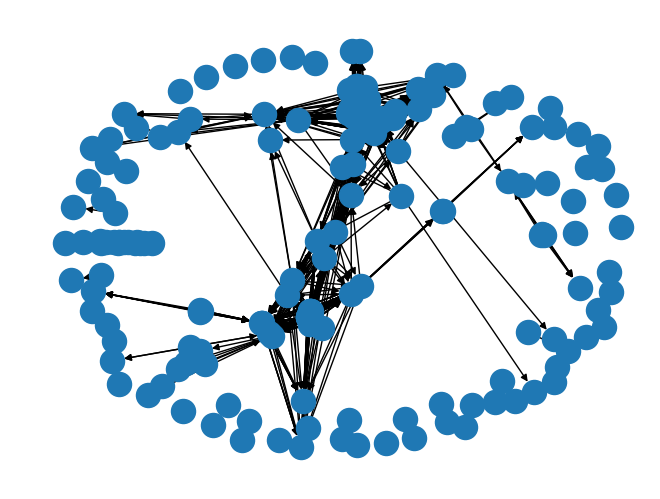

In [10]:
nx.draw(graph)

In [21]:
nx.write_adjlist(graph, "graph.adjlist")

In [22]:
repr(graph.nodes())

"NodeView(('0-0', '1-1', '2-1', '3-0', '4-0', '5-1', '6-0', '7-0', '8-0', '9-0', '10-0', '11-0', '12-1', '13-1', '14-1', '15-1', '16-1', '17-0', '18-1', '19-0', '20-1', '21-0', '22-0', '23-1', '24-1', '25-1', '26-1', '27-1', '28-2', '29-1', '30-2', '31-1', '32-2', '33-1', '34-0', '35-0', '36-0', '37-1', '38-0', '39-0', '40-0', '41-0', '42-1', '43-0', '44-1', '45-1', '46-1', '47-7', '48-3', '49-8', '50-24', '51-4', '52-1', '53-2', '54-1', '55-2', '56-2', '57-2', '58-1', '59-1', '60-1', '61-2', '62-0', '63-2', '64-1', '65-0', '66-0', '67-0', '68-1', '69-0', '70-1', '71-0', '72-1', '73-1', '74-1', '75-1', '76-0', '77-1', '78-1', '79-0', '80-0', '81-1', '82-1', '83-1', '84-1', '85-0', '86-0', '87-0', '88-0', '89-1', '90-0', '91-0', '92-0', '93-1', '94-0', '95-1', '96-1', '97-1', '98-0', '99-3', '100-3', '101-2', '102-2', '103-2', '104-1', '105-2', '106-2', '107-3', '108-1', '109-6', '110-0', '111-1', '112-1', '113-1', '114-0', '115-1', '116-1', '117-0', '118-0', '119-0', '120-0', '121-1', 

In [24]:
nx.read_adjlist("graph.adjlist").nodes()

NodeView(('0-0', '1-1', '2-1', '5-1', '18-1', '25-1', '27-1', '29-1', '30-2', '32-2', '33-1', '52-1', '58-1', '71-0', '72-1', '73-1', '74-1', '75-1', '81-1', '89-1', '108-1', '129-1', '130-1', '132-1', '140-1', '149-1', '152-1', '165-3', '166-0', '197-1', '198-1', '202-1', '203-1', '13-1', '37-1', '40-0', '76-0', '77-1', '78-1', '3-0', '4-0', '22-0', '23-1', '24-1', '26-1', '43-0', '45-1', '46-1', '47-7', '48-3', '49-8', '50-24', '51-4', '53-2', '54-1', '55-2', '56-2', '59-1', '60-1', '61-2', '63-2', '70-1', '82-1', '83-1', '84-1', '93-1', '96-1', '100-3', '102-2', '105-2', '106-2', '107-3', '135-1', '182-0', '6-0', '159-0', '191-0', '7-0', '8-0', '67-0', '69-0', '177-1', '9-0', '10-0', '15-1', '16-1', '28-2', '41-0', '42-1', '66-0', '80-0', '110-0', '111-1', '115-1', '116-1', '186-1', '190-1', '11-0', '12-1', '14-1', '17-0', '19-0', '20-1', '21-0', '31-1', '57-2', '162-0', '199-1', '200-1', '201-1', '34-0', '35-0', '36-0', '38-0', '39-0', '44-1', '193-0', '62-0', '64-1', '65-0', '68-1

In [25]:
sample_graph = nx.DiGraph()
sample_graph.add_nodes_from([0, 1, 2, 3, 4])
sample_graph.add_edge(0, 2)
sample_graph.add_edge(2, 3)
sample_graph.add_edge(3, 4)
sample_graph.add_edge(1, 3)

In [26]:
list(nx.topological_generations(sample_graph))

[[0, 1], [2], [3], [4]]

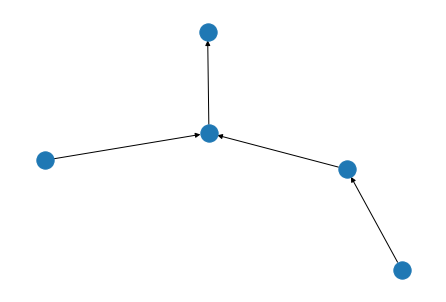

In [27]:
nx.draw(sample_graph)